# Modeling Evaporation and Transpiration

TODO:
* cleaned up until here, 
    * double check the df variable renames got fully renamed (used changed all occurances which can be risky)
    * fix capitalization on the other variables 
    * take out long pathnames and assume local files 
    * get the dataframe column names to be something meaningful
    * maybe break the data into 2 models for some of the null values to get pulled out

In [ ]:
#imports
import pandas as pd
import numpy as np
import math
import numpy
from numpy import random
from scipy.stats import skewnorm
import plotly.graph_objects as go

# Data Import

### Reading in the meterologic data that will be used to train the model

In [50]:
#reading in meterologic data
waseca = pd.read_excel('Data/waseca.xls')
print("Shape of dataframne:", waseca.shape)
waseca.head()

Shape of dataframne: (62, 9)


,date,tmax,tmin,rain,pan,srad,rhmax,rhmin,wd spd
0,1985-06-01,20.3,8.5,0.51,3.81,2.64,94.0,64.0,4.41
1,1985-06-02,15.5,4.5,0.00,3.30,4.85,89.0,45.0,3.65
2,1985-05-03,18.9,5.1,0.00,4.32,5.80,89.0,39.0,2.25
3,1985-06-04,18.3,11.4,0.00,4.32,2.34,83.0,61.0,2.24
4,1985-06-05,23.4,8.1,0.00,8.64,8.51,89.0,22.0,2.53


Initial investigation/cleaning

In [55]:
#checking for nulls
waseca.isnull().any()

date      True
tmax      True
tmin      True
rain      True
pan       True
srad      True
rhmax     True
rhmin     True
wd spd    True
dtype: bool

In [58]:
#looking at how many nulls there are: just 1
waseca.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    61 non-null     datetime64[ns]
 1   tmax    61 non-null     float64       
 2   tmin    61 non-null     float64       
 3   rain    61 non-null     float64       
 4   pan     61 non-null     float64       
 5   srad    61 non-null     float64       
 6   rhmax   61 non-null     float64       
 7   rhmin   61 non-null     float64       
 8   wd spd  61 non-null     float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 4.5 KB


In [64]:
#looking for when a metric is null:
waseca[waseca['tmax'].isnull()]

,date,tmax,tmin,rain,pan,srad,rhmax,rhmin,wd spd
30,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: >

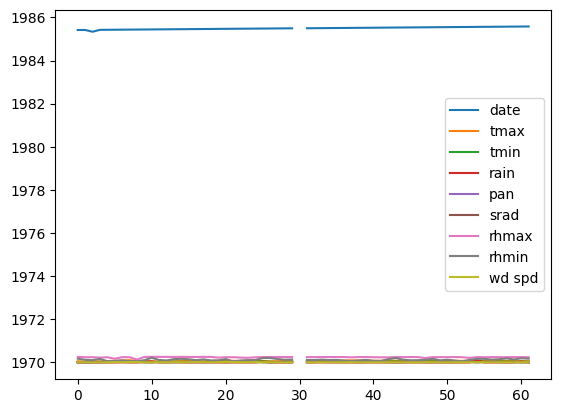

In [65]:
#this looks like a missed point of collection, noting the existence, but I'm not going to pull out 
waseca.plot()

In [ ]:
#looks like 30 is the only hole. I will note it's presence and possibly take it out later.

### Reading in observed evapotranspiration data to test model

In [ ]:
#reading in observed ET data
observed_et_data_waseca_corn_r204 = pd.read_excel('Data/ObservedET_Waseca_2007.xls', sheet_name = 'Corn_R204')
print("Corn Data frame shape:", observed_et_data_waseca_corn_r204.shape)
observed_et_data_waseca_corn_r204.head(2)

### Reading in weather data observed in 2007

In [ ]:
#reading in Weather data observed 2007
observed_weather_waseca_2007 = pd.read_excel('Data/WasecaWeather_2006and2007final.xls', sheet_name = '2007')
print(observed_weather_waseca_2007.shape)
observed_weather_waseca_2007.head()

In [ ]:

RadiationCalltest = float(observed_weather_waseca_2007.at[2,'Unnamed: 8'])
print(RadiationCalltest)

In [ ]:

wind = observed_weather_waseca_2007.iat[2,11]
print(wind)

ΔTmin = observed_weather_waseca_2007.at[3,'Unnamed: 3']-observed_weather_waseca_2007.at[2,'Unnamed: 3']
ΔTmax = observed_weather_waseca_2007.at[3,'Unnamed: 2']-observed_weather_waseca_2007.at[2,'Unnamed: 2']
print(ΔTmin, ΔTmax)

type(observed_weather_waseca_2007.iat[3, 6])

print(observed_weather_waseca_2007.at[2,'Unnamed: 7'])

print(observed_weather_waseca_2007.iat[2,4])

actualday=[]
actualprecip = []
for i in range(2,155):
    actualday.append(observed_weather_waseca_2007.iat[i,1])
    actualprecip.append(observed_weather_waseca_2007.iat[i,4])
    
#print(actualday)
print(len(actualprecip))

In [ ]:
#Calculating transition probabilities to be able to calculate the meteorolgic values
rain = waseca["rain"]
totalDays = len(rain)
print("totalDays: ", totalDays)
rainyDays = []
for i in range(0,61):
    if rain[i] != 0:
        rainyDays.append(i)

wetDays = len(rainyDays)
print("wetDays: ", wetDays)

dryDays = totalDays-wetDays
print("dryDays: ", dryDays)

ProbWetDay = wetDays/totalDays #See page 2-40 for explanation
print("ProbWetDay: ", ProbWetDay)
ProbDryDay = 1-ProbWetDay
print("ProbDryDay: ", ProbDryDay)

WettoWet = 0
WettoDry = 0
DrytoWet = 1 #we can't compare to day negative one, and so we are assuming the day is dry to match the sums as seen in table 2.2
DrytoDry = 0
for i in range(0,61):
    j = i+1
    if(rain[i] !=0 and rain[j]!=0):
        WettoWet += 1
    elif(rain[i] !=0 and rain[j]==0):
        WettoDry +=1
    elif(rain[i] ==0 and rain[j]!=0):
        DrytoWet +=1
    else:
        DrytoDry +=1

print("WettoWet: ", WettoWet)
print("WettoDry: ", WettoDry)
print("DrytoWet: ", DrytoWet)
print("DrytoDry: ", DrytoDry)

PWW = WettoWet/wetDays
print("PWW:", PWW)
PWD = WettoDry/dryDays
print("PWD:", PWD)
PDW = 1-PWW
print("PDW:",PDW)
#Data Check
#PDW2 = DrytoWet/wetDays
#print(PDW2)
PDD = 1-PWD
print("PDD:", PDD)
#Data Check
#PDD2 = DrytoDry/dryDays
#print(PDD2)

In [ ]:
#make a function to calculate Richardson's prediction
#Note: Assume coefficients are the same for rochester MN:Table. 2.4. Cosine Coefficient for Maximum Temperature Statistics, Rochester, MN.

#==================================================================================================================

#========================================================================================================
#Because the first day is dry, we will set the "Global variables" called only on the first iteration of the loop
#we will use the coefficients correlated for the P(W/D)
C0 = 0.225
C1 = -0.059
C2 = 0.008
C3 = 0.008
            
theta1= 0.236
theta2= 0.981
theta3= 0.489
#========================================================================================================
#these get overwritten when in the loop
#================================================================================================================

#===================================
#Period
T=365/(2*math.pi)

#====================================================================================================
#Function to calculate the vday value to compare against the random value to determine if the day will be wet or dry
#==============================================================================================================
def vdaycalc(day,currentState):
        
    if currentState == "wet": # P(W/W) 
        C0 = .392
        C1 = -.035
        C2 = -.055
        C3 = .01
            
        theta1= 0.392 
        theta2= -0.982
        theta3= -0.343 
            
    else: #Current state == dry P(W/D)
        C0 = 0.225
        C1 = -0.059
        C2 = 0.008
        C3 = 0.008
            
        theta1= 0.236
        theta2= 0.981
        theta3= 0.489
    #calculate the Richardson estimation of the parameters based on his eqn 2.5.11:
    vday=float(C0+C1*math.cos(day/T+theta1)+C2*math.cos(2*day/T+theta2)+C3*math.cos(3*day/T+theta3))
    return(vday)

# Calculate If the day is wet or dry
currentStatei = []
currentState = "dry" #chosen such that the above transition probabilities would sum correctly
precip = []
for day in range(366):
    #call the Richardson estimation function inside the loop
    vday=vdaycalc(day,currentState)
    randomdayvalue=random.random()
    if vday==randomdayvalue:
        print('something is wrong')
    elif randomdayvalue>vday:
        nextday = "dry"
        P=0
    else:
        #estimated based on the vday equation and the respective coefficient from the data given 
        mu = float(C0+C1*math.cos(day/T+theta1)+C2*math.cos(2*day/T+theta2)+C3*math.cos(3*day/T+theta3))
        #Changed the precip to fit a skewed normal estimation based on Bruce's office hours
        P=mu*float(skewnorm.rvs(a=2, size=1)) #mm
        #possible source of error: forcing to positive
        if P<0:
            P=abs(mu*float(skewnorm.rvs(a=2, size=1))) #mm
        nextday = "wet"
    precip.append(P)
    currentStatei.append(currentState)
    currentState=nextday
    
yearRecord = pd.DataFrame(
    {'Current State': currentStatei,
     'Precip': precip
    })

N = 365
t = numpy.linspace(0, 1, 365)

print(yearRecord)
#Simulated precip
fig = go.Figure(data=go.Scatter(x=t, y=precip, mode='markers'))

fig.show()

In [ ]:
#Infiltration component

#May 39th is the 150th day of the year, pull 151 column for soil moisture information as initial
initialsoilmoisturecontent = float(observed_et_data_waseca_corn_r204.at[31,'Soil Moisture Content'])
#alternative initial estimation method:
#θi = θwp+0.5*(θfc-θwp) #initial state of the soil moisture
#=====================================================================================================
# Parameter estimation
#soil tank depth mm to correlate to the soil information for the Nicollet Clay Loam at .2 m
#soil information from table given in the site
D=200
θs=0.48
θfc=0.41
θwp=0.26
b=13.4
Ψb=108 #mm of H20
Ks = 55.2 #mm/d saturated conductivity
θi=initialsoilmoisturecontent #global variable to use for the first iteration in the look
#======================================================================================================

#====================================================================================================
#Calculating net infiltration and percolation
#=====================================================================================================
def calcfp(day):
    Net_Inf_Per = (θfc-θi)*D
    if precip[day]<Net_Inf_Per:
        #precip[day] = precipitation simulated for that day
        Net_Inf_Per = precip[day]
    return Net_Inf_Per

#====================================================================================================
#Calculating Net Radiation
#assuming the same parameters given on page 6-50 for grass conditions
#=====================================================================================================
bo = -0.52 #MJ/m2/d 
b1 = 0.75 #MJ/m2/d
def calcRn(day):
    row = day-118
    Rsi=float(observed_weather_waseca_2007.at[row,'Unnamed: 8'])
    Rn = bo+b1*Rsi
    return Rn

#====================================================================================================
#Calculating RET Using Penmans
#referencing page  6-50; 6-82 for algorithm summary
#=====================================================================================================
γc = 0.066 #kPa/K = 0.66 mbar/K.
L = 2453 #MJ m-3
G=0 #for a daily time step
cp = 1 #kJ kg-1 K-1
#Compute log profile resistance constant:
def calcΨRET(day):
    rowcurrentday=day-118
    rowyesterday=day-119
    ΔTmin = observed_weather_waseca_2007.at[rowcurrentday,'Unnamed: 3']-observed_weather_waseca_2007.at[rowyesterday,'Unnamed: 3']
    ΔTmax = observed_weather_waseca_2007.at[rowcurrentday,'Unnamed: 2']-observed_weather_waseca_2007.at[rowyesterday,'Unnamed: 2']
    Δhat = (ΔTmin+ΔTmax)/2 #C
    U2= observed_weather_waseca_2007.iat[rowcurrentday,11] #km d-1
    fu= 6.43*(1+0.0062*U2) #MJ m-2 d-1 kPa-1
    esatmin=((observed_weather_waseca_2007.at[rowcurrentday,'Unnamed: 3']+273.15)/273.16)**(-4.811)*math.exp(24.134-6726.73/(observed_weather_waseca_2007.at[rowcurrentday,'Unnamed: 3']+273.15)) #Kpa eqn 6.4.2
    esatmax=((observed_weather_waseca_2007.at[rowcurrentday,'Unnamed: 2']+273.15)/273.16)**(-4.811)*math.exp(24.134-6726.73/(observed_weather_waseca_2007.at[rowcurrentday,'Unnamed: 2']+273.15)) #Kpa eqn 6.4.2
    rhmax=observed_weather_waseca_2007.at[rowcurrentday,'Unnamed: 9']/100
    rhmin=observed_weather_waseca_2007.at[rowcurrentday,'Unnamed: 10']/100
    dailyvaporpressuredeficit=(esatmax+esatmax)/2-(esatmin*rhmax+esatmax*rhmin)/2
    ΨRET=Δhat/(Δhat+γc)*(calcRn(day)-G)+γc/(Δhat+γc)*fu*dailyvaporpressuredeficit
    return ΨRET

def calcRETpenm(day):
    RET=calcΨRET(day)/L
    return RET

def calcET(day):
    
    #calculating soil moisture availability factor
    #Coefficient of rapid evaporation loss
    #look up Kr: http://www.fao.org/3/X0490e/x0490e0c.htm from generalized figure
    if θi>θfc:
        Kw=1
        #Kr=1
    elif θi<θwp:
        Kw=0
        #Kr=.4
    else:
        Aw=100*(θi-θwp)/(θfc-θwp)
        Kw=np.log(Aw+1)/np.log(101)
        #Kr=.7
        
    #crop coefficient for corn
    Kc = .3 #table 6.6
    
    
    ET=(Kc*Kw)*calcRETpenm(day)
    return ET
    

#====================================================================================================
#Calculating soil moisture content Penman
#=====================================================================================================
def calcθi(day,θi):
    θi=θi+calcfp(day)/D-calcET(day)/D
    return θi

#Pan Method
Kc = .3 #table 6.6
#====================================================================================================
#Pan Evap Method
#=====================================================================================================
def calcETpanmeth(day):
    row=day-118
    RET=cp*observed_weather_waseca_2007.at[row,'Unnamed: 7']
        
    PET=Kc*RET
    if θi>θfc:
        Kw=1
        #Kr=1
    elif θi<θwp:
        Kw=0
       #Kr=.4
    else:
        Aw=100*(θi-θwp)/(θfc-θwp)
        Kw=np.log(Aw+1)/np.log(101)
        Kr=.7
        
    #crop coefficient for corn
    ET=Kw*PET
    return ET

#====================================================================================================
#Calculating soil moisture content Pan evap method
#=====================================================================================================
def calcθipan(day,θi):
    θi=θi+calcfp(day)/D-calcETpanmeth(day)/D
    return θi


ETpan= []
soilmoisturepan = []
soilmoistureContent = []
ETlist = []
infilperclist=[]

for day in range(152,273,1):
    ET = 1000*calcET(day)
    ETlist.append(ET)
    fp=calcfp(day)
    infilperclist.append(fp)
    θi = calcθi(day,θi)
    soilmoistureContent.append(θi)
    ETPan = calcETpanmeth(day)
    ETpan.append(ETPan)
    θPan =  calcθipan(day,θi)
    soilmoisturepan.append(θPan)
    
df = pd.DataFrame({'ET Penman':ETlist, 'θ Penman':soilmoistureContent, 'ET Pan':ETpan, 'θ Pan':soilmoisturepan})
print(df)

observedsoilmoisture= observed_et_data_waseca_corn_r204['Unnamed: 3'].values.tolist()
observedET= observed_et_data_waseca_corn_r204['ET'].values.tolist()


t = numpy.linspace(152, 273, 121)
soilmoisture = go.Figure(data=go.Scatter(x=t, y=soilmoistureContent, name='Soil Moisture Content Penman', mode='markers'))
soilmoisture.add_trace(go.Scatter(x=t, y=soilmoisturepan, name='Soil Moisture Content Pan Evap', mode='markers'))
soilmoisture.add_trace(go.Scatter(x=t, y=observedsoilmoisture, name='Soil Moisture Content observed', mode='markers'))
soilmoisture.show()

ET = go.Figure(data=go.Scatter(x=t, y=ETlist, name='ET Penman', mode='markers', marker_color='rgba(152, 0, 0, .8)'))
ET.add_trace(go.Scatter(x=t, y=ETpan, name='ET pan', mode='markers'))
ET.add_trace(go.Scatter(x=t, y=observedET, name='ET Observed', mode='markers'))
ET.show()

#ET.write_html(r'C:\Users\clair\Downloads\ETgraph.html')
#soilmoisture.write_html(r'C:\Users\clair\Downloads\soilmoisturegraph.html')

In [ ]:
#With actual precip data

initialsoilmoisturecontent = float(observed_et_data_waseca_corn_r204.at[31,'Soil Moisture Content'])
#alternative initial estimation method:
#θi = θwp+0.5*(θfc-θwp) #initial state of the soil moisture
#=====================================================================================================
# Parameter estimation
#soil tank depth mm to correlate to the soil information for the Nicollet Clay Loam at .2 m
#soil information from table given in the site
D=200
θs=0.48
θfc=0.41
θwp=0.26
b=13.4
Ψb=108 #mm of H20
Ks = 55.2 #mm/d saturated conductivity
θi=initialsoilmoisturecontent #global variable to use for the first iteration in the look
#======================================================================================================

#====================================================================================================
#Calculating net infiltration and percolation
#=====================================================================================================
def calcfp(day):
    Net_Inf_Per = (θfc-θi)*D
    if actualprecip[day-150]<Net_Inf_Per:
        #precip[day] = precipitation simulated for that day
        Net_Inf_Per = precip[day]
    return Net_Inf_Per

#====================================================================================================
#Calculating Net Radiation
#assuming the same parameters given on page 6-50 for grass conditions
#=====================================================================================================
bo = -0.52 #MJ/m2/d 
b1 = 0.75 #MJ/m2/d
def calcRn(day):
    row = day-118
    Rsi=float(observed_weather_waseca_2007.at[row,'Unnamed: 8'])
    Rn = bo+b1*Rsi
    return Rn

#====================================================================================================
#Calculating RET Using Penmans
#referencing page  6-50; 6-82 for algorithm summary
#=====================================================================================================
γc = 0.066 #kPa/K = 0.66 mbar/K.
L = 2453 #MJ m-3
G=0 #for a daily time step
cp = 1 #kJ kg-1 K-1
#Compute log profile resistance constant:
def calcΨRET(day):
    rowcurrentday=day-118
    rowyesterday=day-119
    ΔTmin = observed_weather_waseca_2007.at[rowcurrentday,'Unnamed: 3']-observed_weather_waseca_2007.at[rowyesterday,'Unnamed: 3']
    ΔTmax = observed_weather_waseca_2007.at[rowcurrentday,'Unnamed: 2']-observed_weather_waseca_2007.at[rowyesterday,'Unnamed: 2']
    Δhat = (ΔTmin+ΔTmax)/2 #C
    U2= observed_weather_waseca_2007.iat[rowcurrentday,11] #km d-1
    fu= 6.43*(1+0.0062*U2) #MJ m-2 d-1 kPa-1
    esatmin=((observed_weather_waseca_2007.at[rowcurrentday,'Unnamed: 3']+273.15)/273.16)**(-4.811)*math.exp(24.134-6726.73/(observed_weather_waseca_2007.at[rowcurrentday,'Unnamed: 3']+273.15)) #Kpa eqn 6.4.2
    esatmax=((observed_weather_waseca_2007.at[rowcurrentday,'Unnamed: 2']+273.15)/273.16)**(-4.811)*math.exp(24.134-6726.73/(observed_weather_waseca_2007.at[rowcurrentday,'Unnamed: 2']+273.15)) #Kpa eqn 6.4.2
    rhmax=observed_weather_waseca_2007.at[rowcurrentday,'Unnamed: 9']/100
    rhmin=observed_weather_waseca_2007.at[rowcurrentday,'Unnamed: 10']/100
    dailyvaporpressuredeficit=(esatmax+esatmax)/2-(esatmin*rhmax+esatmax*rhmin)/2
    ΨRET=Δhat/(Δhat+γc)*(calcRn(day)-G)+γc/(Δhat+γc)*fu*dailyvaporpressuredeficit
    return ΨRET

def calcRETpenm(day):
    RET=calcΨRET(day)/L
    return RET

def calcET(day):
    
    #calculating soil moisture availability factor
    #Coefficient of rapid evaporation loss
    #look up Kr: http://www.fao.org/3/X0490e/x0490e0c.htm from generalized figure
    if θi>θfc:
        Kw=1
        #Kr=1
    elif θi<θwp:
        Kw=0
        #Kr=.4
    else:
        Aw=100*(θi-θwp)/(θfc-θwp)
        Kw=np.log(Aw+1)/np.log(101)
        #Kr=.7
        
    #crop coefficient for corn
    Kc = .3 #table 6.6
    
    
    ET=(Kc*Kw)*calcRETpenm(day)
    return ET
    

#====================================================================================================
#Calculating soil moisture content Penman
#=====================================================================================================
def calcθi(day,θi):
    θi=θi+calcfp(day)/D-calcET(day)/D
    return θi

#Pan Method
Kc = .3 #table 6.6
#====================================================================================================
#Pan Evap Method
#=====================================================================================================
def calcETpanmeth(day):
    row=day-118
    RET=cp*observed_weather_waseca_2007.at[row,'Unnamed: 7']
        
    PET=Kc*RET
    if θi>θfc:
        Kw=1
        #Kr=1
    elif θi<θwp:
        Kw=0
       #Kr=.4
    else:
        Aw=100*(θi-θwp)/(θfc-θwp)
        Kw=np.log(Aw+1)/np.log(101)
        Kr=.7
        
    #crop coefficient for corn
    ET=Kw*PET
    return ET

#====================================================================================================
#Calculating soil moisture content Pan evap method
#=====================================================================================================
def calcθipan(day,θi):
    θi=θi+calcfp(day)/D-calcETpanmeth(day)/D
    return θi


ETpan= []
soilmoisturepan = []
soilmoistureContent = []
ETlist = []
infilperclist=[]

for day in range(152,273,1):
    ET = 1000*calcET(day)
    ETlist.append(ET)
    fp=calcfp(day)
    infilperclist.append(fp)
    θi = calcθi(day,θi)
    soilmoistureContent.append(θi)
    ETPan = calcETpanmeth(day)
    ETpan.append(ETPan)
    θPan =  calcθipan(day,θi)
    soilmoisturepan.append(θPan)
    
df = pd.DataFrame({'ET Penman':ETlist, 'θ Penman':soilmoistureContent, 'ET Pan':ETpan, 'θ Pan':soilmoisturepan})
print(df)

observedsoilmoisture= observed_et_data_waseca_corn_r204['Unnamed: 3'].values.tolist()
observedET= observed_et_data_waseca_corn_r204['ET'].values.tolist()


t = numpy.linspace(152, 273, 121)
soilmoisture = go.Figure(data=go.Scatter(x=t, y=soilmoistureContent, name='Soil Moisture Content Penman', mode='markers'))
soilmoisture.add_trace(go.Scatter(x=t, y=soilmoisturepan, name='Soil Moisture Content Pan Evap', mode='markers'))
soilmoisture.add_trace(go.Scatter(x=t, y=observedsoilmoisture, name='Soil Moisture Content observed', mode='markers'))
soilmoisture.show()

ET = go.Figure(data=go.Scatter(x=t, y=ETlist, name='ET Penman', mode='markers', marker_color='rgba(152, 0, 0, .8)'))
ET.add_trace(go.Scatter(x=t, y=ETpan, name='ET pan', mode='markers'))
ET.add_trace(go.Scatter(x=t, y=observedET, name='ET Observed', mode='markers'))
ET.show()

#ET.write_html(r'C:\Users\clair\Downloads\ETgraph.html')
#soilmoisture.write_html(r'C:\Users\clair\Downloads\soilmoisturegraph.html')